# Importing the Relevant Libraries

In [1]:
import os  #To load the dataset
import time #To time the training
from sklearn.model_selection import train_test_split    #For splitting the train images into a train and a validation split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix     #Metrics for evaluation
import matplotlib.pyplot as plt     #For plotting the various curves, images etc.

In [2]:
import torch
from torch import nn    #To allow modifications to the model architecture
from torch import optim #Contains optimizers

In [3]:
from torchvision import transforms      #To transform the dataset into the form the model desires
from torch.utils.data import Dataset, DataLoader    #To load the dataset via the path, we will use the Torch DataLoader and Dataset 
from PIL import Image   #To display the images
from transformers import AutoModelForImageClassification  #To access Dinov2 model

/DATA2/dse313/group10/env_assignment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading the Dataset

A Class which is a child class of Dataset, used to load the image dataset via DataLoader

In [4]:
class LoadData(Dataset):
    def __init__(self, path, trf, isTrain):
        self.path=path
        self.trf=trf
        self.isTrain=isTrain

        self.labels=['abandoned','commercial','industrial','others','religious','residential','underconstruction']
        self.data=self.load_data()

    #Function to load the path of the data and allocate it to test or train based on its name
    def load_data(self):   
        data=[]
        for label_idx,label in enumerate(self.labels):
            loc=self.path+label+'/'
            type='train' if self.isTrain else 'test'

            for file in os.listdir(loc):
                if file.startswith(type):
                    file_path=loc+file

                    data.append((file_path, label_idx)) 
        
        return data
    def __len__(self):
        return len(self.data)
    
    #Necessary for a DataLoader class, loads the image from the path and applies the suitable transformation
    def __getitem__(self,idx):
        img_path, label= self.data[idx]
        img=Image.open(img_path).convert('RGB')
        img=self.trf(img)
        return img, label

Transformation for the data to bring uniformity

In [5]:
# Transformation for the data
trf=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

Creating, splitting and loading the image dataset into a train, valid and test split. 25% of train data is used for validation

In [6]:
path='/DATA2/dse313/group10/pure/pure/'
train_dataset= LoadData(path, trf, True)
test_dataset= LoadData(path, trf, False)

In [7]:
train_split, val_split= train_test_split(train_dataset, test_size=0.25, random_state=2)

In [8]:
batch=32 #Batch size 
# train_loader=DataLoader(train_dataset, batch_size=batch, shuffle=True)
train_loader=DataLoader(train_split, batch_size=batch, shuffle=True)
val_loader=DataLoader(val_split,batch_size=batch, shuffle= True)
test_loader=DataLoader(test_dataset, batch_size=batch, shuffle= True)

# Visualizing the Dataset

A count of the different classes in the dataset

In [9]:
def visualize_count(dataset,title):
    print()
    print(f'::::{title}::::')
    print('Total size of the dataset:', len(dataset))
    
    class_labels=dataset.labels
    count=[0]*len(class_labels)
    for img, label in dataset:
        count[label]+=1
    merged=dict(zip(class_labels,count))
    print(merged)


visualize_count(train_dataset, 'Training Dataset')
visualize_count(test_dataset, 'Testing Dataset')


::::Training Dataset::::
Total size of the dataset: 2595
{'abandoned': 85, 'commercial': 626, 'industrial': 199, 'others': 244, 'religious': 94, 'residential': 1207, 'underconstruction': 140}

::::Testing Dataset::::
Total size of the dataset: 391
{'abandoned': 21, 'commercial': 90, 'industrial': 37, 'others': 79, 'religious': 23, 'residential': 106, 'underconstruction': 35}


A Function which displays 15 random images from a dataset

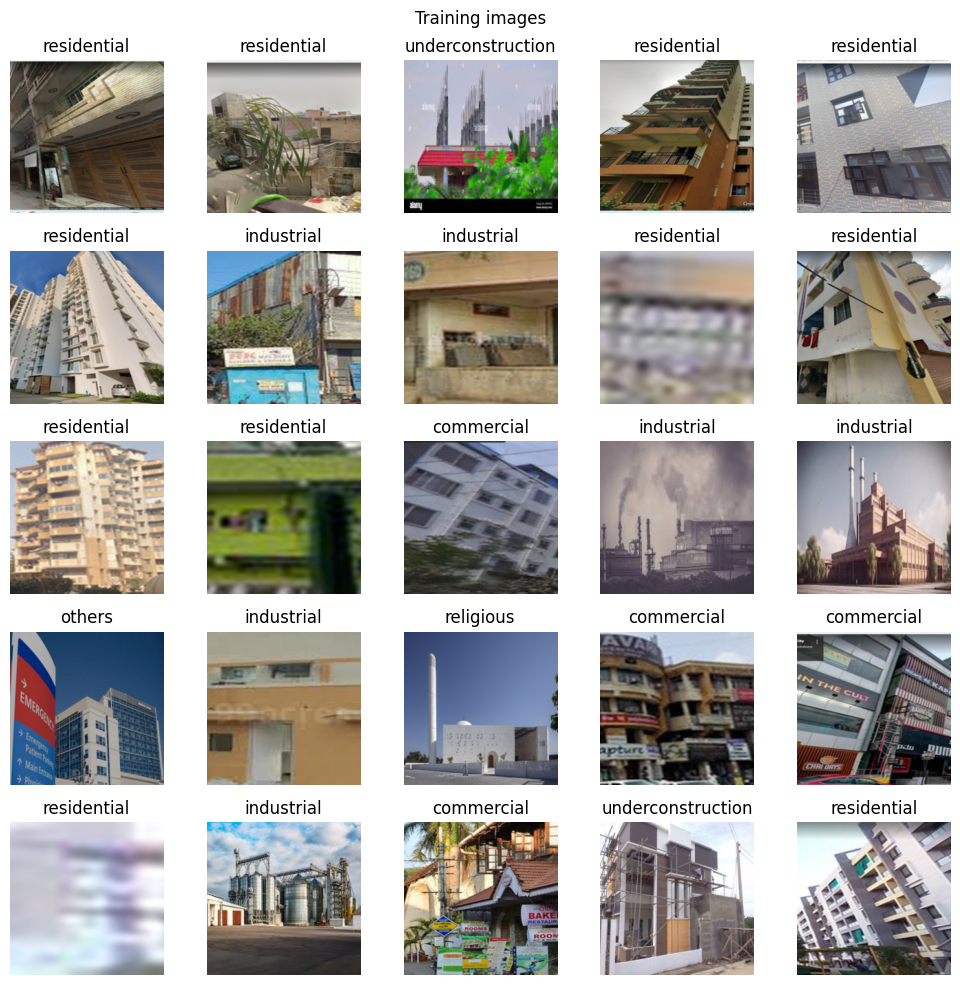

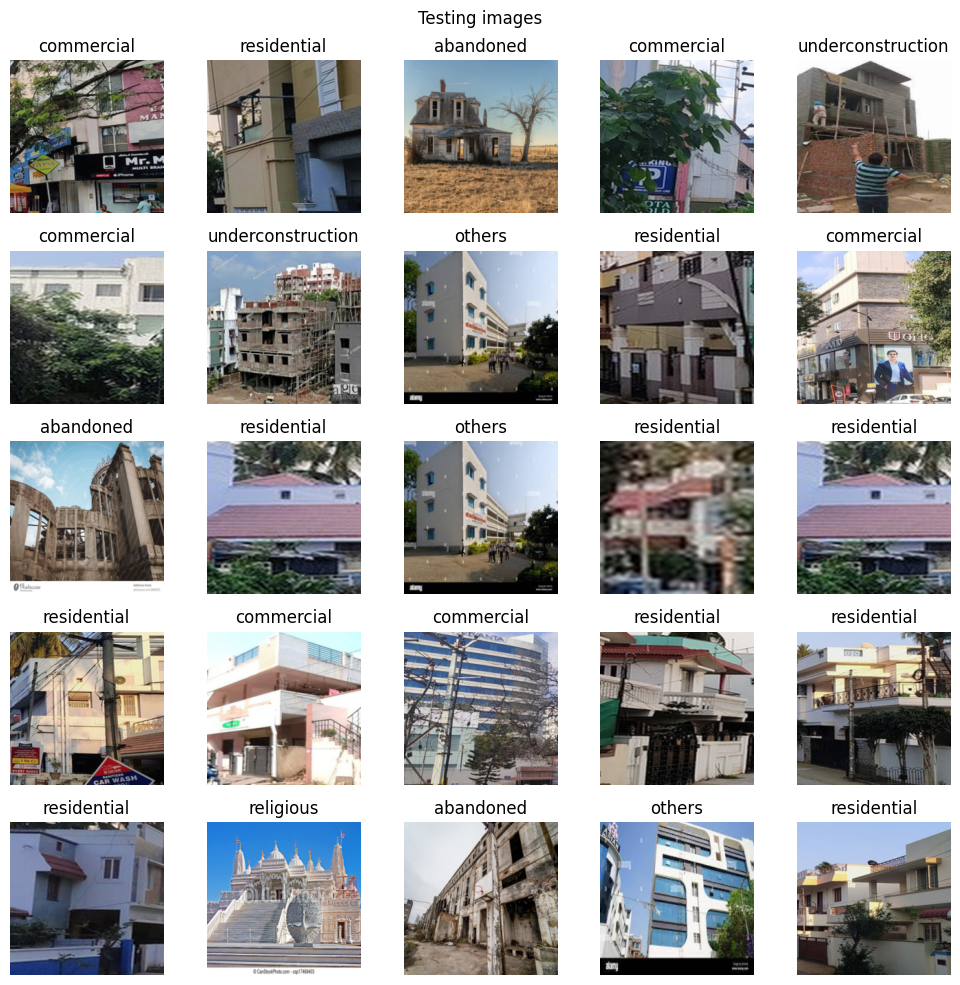

In [10]:
import random
def visualize_samples(dataset,title):
    
    fig, ax= plt.subplots(nrows=5, ncols=5, figsize=[10,10])
    fig.suptitle(title)

    for i,axi in enumerate(ax.flat):
        idx=random.randint(0,len(dataset)-1)
        img, label= dataset[idx]

        axi.imshow(transforms.ToPILImage()(img))
        axi.set_title(dataset.labels[label])
        axi.axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset,'Training images')
visualize_samples(test_dataset,'Testing images')

# Training the model

Loading the pretrained DINOv2 model from the transformers library

In [11]:
model=AutoModelForImageClassification.from_pretrained('facebook/dinov2-base-imagenet1k-1-layer',
                                                      ignore_mismatched_sizes= True)

Freezing the model as we just need to train the final layer

In [12]:
for each_param in model.parameters():
    each_param.requires_grad=False

Shifting to GPU

In [15]:
device= torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda:1


In [16]:
# Checking the model summary
print(model)

Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
       

Creating a new final layer for the model based on the new number of classes

In [17]:
num_classes=len(train_dataset.labels)
model.config.num_labels=num_classes
model.classifier= nn.Linear(in_features=1536, out_features=num_classes)
model.to(device)

Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
       

Defining the Hyperparameters

In [18]:
loss_fun=nn.CrossEntropyLoss()
# optimizer=optim.SGD(params=model.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
optimizer= optim.Adam(params=model.parameters(), lr=5e-4)
epochs=15

In [19]:
train_losses=[]
train_accs=[]
val_losses=[]
val_accs=[]

Training the model

In [20]:
for epoch in range(epochs):
    
    #Training 
    model.train()
    tot_train_loss=0
    train_correct=0
    train_tot=0

    tick= time.time()

    for batch_id, (imgs, labels) in enumerate(train_loader):
        #Sending the data to the device
        imgs=imgs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        #Fwd Pass
        out=model(imgs)
        loss=loss_fun(out.logits,labels)

        #Bwd Pass
        loss.backward()
        optimizer.step()

        tot_train_loss+=loss.item()*imgs.size(0)

        _,pred=torch.max(out.logits,1)
        train_correct+=(pred==labels).sum().item()
        train_tot+=labels.size(0)

    train_loss= tot_train_loss/len(train_loader.dataset)
    train_acc= train_correct/train_tot
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #Validation
    model.eval()
    tot_val_loss=0
    val_correct=0
    val_tot=0

    with torch.no_grad():
        for val_imgs, val_labels in val_loader:
            val_imgs=val_imgs.to(device)
            val_labels=val_labels.to(device)

            val_out=model(val_imgs)
            vloss= loss_fun(val_out.logits,val_labels)
            tot_val_loss+=vloss.item()*val_imgs.size(0)

            _, val_pred= torch.max(val_out.logits,1)
            val_correct+=(val_pred==val_labels).sum().item()
            val_tot+=val_labels.size(0)

    val_loss= tot_val_loss/len(val_loader.dataset)
    val_acc= val_correct/val_tot
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    tock=time.time()
    tot_time=tock-tick

    print(f'Epoch:{epoch+1}\t Train_Loss: {train_loss:.4f}\t Val_Loss: {val_loss:.4f}\t Train_Acc: {train_acc:.4f}\t Val_Acc: {val_acc:.4f}\t Time: {tot_time:.2f} seconds')

Epoch:1	 Train_Loss: 0.7209	 Val_Loss: 0.4628	 Train_Acc: 0.7533	 Val_Acc: 0.8644	 Time: 25.66 seconds
Epoch:2	 Train_Loss: 0.3223	 Val_Loss: 0.4276	 Train_Acc: 0.8926	 Val_Acc: 0.8598	 Time: 9.90 seconds
Epoch:3	 Train_Loss: 0.2443	 Val_Loss: 0.3718	 Train_Acc: 0.9152	 Val_Acc: 0.8798	 Time: 10.08 seconds
Epoch:4	 Train_Loss: 0.1944	 Val_Loss: 0.3618	 Train_Acc: 0.9363	 Val_Acc: 0.8829	 Time: 9.92 seconds
Epoch:5	 Train_Loss: 0.1634	 Val_Loss: 0.3694	 Train_Acc: 0.9538	 Val_Acc: 0.8767	 Time: 10.08 seconds
Epoch:6	 Train_Loss: 0.1401	 Val_Loss: 0.3678	 Train_Acc: 0.9625	 Val_Acc: 0.8814	 Time: 10.14 seconds
Epoch:7	 Train_Loss: 0.1223	 Val_Loss: 0.3560	 Train_Acc: 0.9656	 Val_Acc: 0.8844	 Time: 9.86 seconds
Epoch:8	 Train_Loss: 0.1071	 Val_Loss: 0.3668	 Train_Acc: 0.9743	 Val_Acc: 0.8814	 Time: 10.21 seconds
Epoch:9	 Train_Loss: 0.0942	 Val_Loss: 0.3511	 Train_Acc: 0.9789	 Val_Acc: 0.8998	 Time: 9.98 seconds
Epoch:10	 Train_Loss: 0.0879	 Val_Loss: 0.3519	 Train_Acc: 0.9784	 Val_Acc: 0

# Evaluating the model

Plotting the Loss and Accuracy Curves

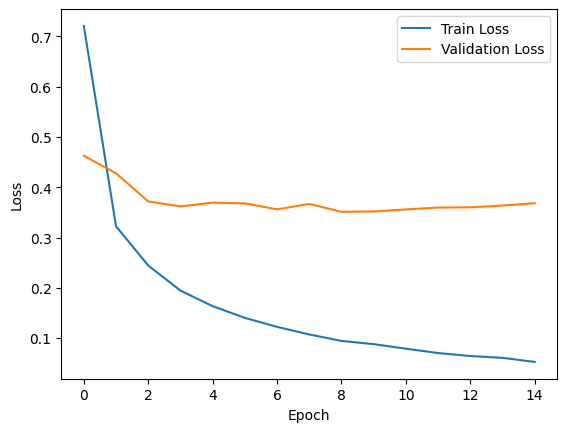

In [21]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

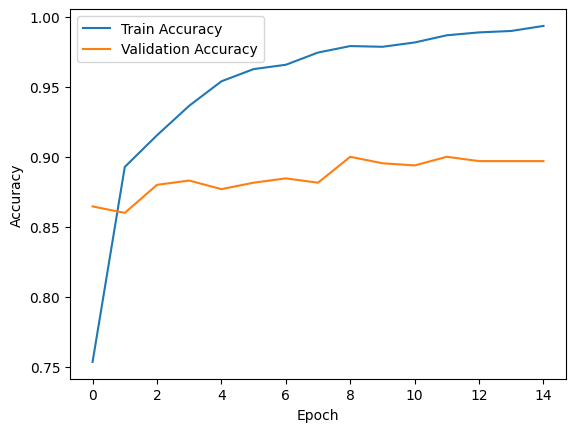

In [22]:
plt.figure()
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Function to print the classification report and the confusion matrix for each split

In [23]:
def eval_model(model, data):
    model.eval()
    all_labels=[]
    preds=[]

    with torch.no_grad():
        for imgs, labels in data:
            imgs= imgs.to(device)
            labels=labels.to(device)
            out=model(imgs)
            _, pred= torch.max(out.logits ,1)

            all_labels.extend(labels.cpu().numpy())
            preds.extend(pred.cpu().numpy())

    print('Classification Report:')
    print(classification_report(all_labels,preds, target_names=train_dataset.labels))

    print('Confusion Matrix:')
    cm=confusion_matrix(all_labels,preds)
    disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.labels)
    disp.plot()
    plt.tight_layout()
    disp.ax_.set_xticklabels(labels= train_dataset.labels, rotation=90)
    plt.show()



Evaluation on train split

Classification Report:
                   precision    recall  f1-score   support

        abandoned       1.00      1.00      1.00        63
       commercial       1.00      0.98      0.99       480
       industrial       1.00      1.00      1.00       158
           others       1.00      1.00      1.00       175
        religious       1.00      1.00      1.00        70
      residential       0.99      1.00      0.99       893
underconstruction       1.00      1.00      1.00       107

         accuracy                           0.99      1946
        macro avg       1.00      1.00      1.00      1946
     weighted avg       0.99      0.99      0.99      1946

Confusion Matrix:


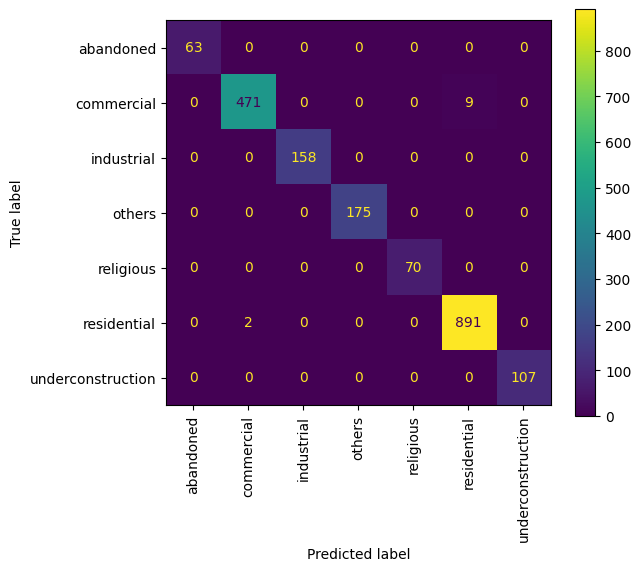

In [24]:
eval_model(model, train_loader)

Evaluation on validation split

Classification Report:
                   precision    recall  f1-score   support

        abandoned       0.95      0.86      0.90        22
       commercial       0.86      0.88      0.87       146
       industrial       0.75      0.80      0.78        41
           others       0.94      0.87      0.90        69
        religious       0.92      0.92      0.92        24
      residential       0.92      0.92      0.92       314
underconstruction       0.88      0.88      0.88        33

         accuracy                           0.90       649
        macro avg       0.89      0.88      0.88       649
     weighted avg       0.90      0.90      0.90       649

Confusion Matrix:


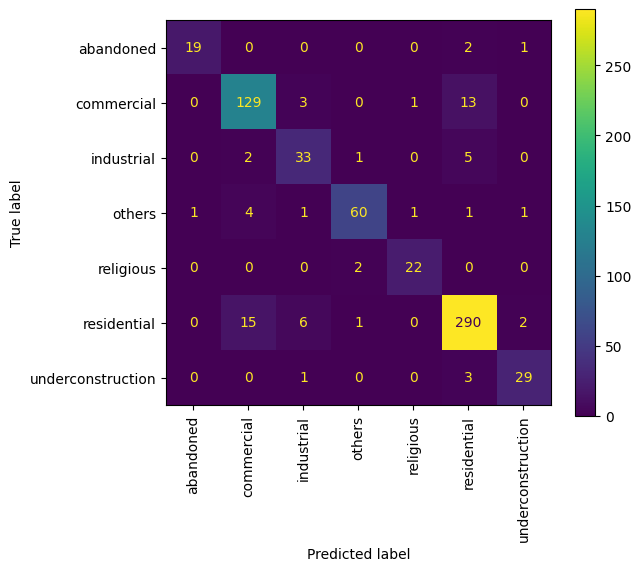

In [25]:
eval_model(model, val_loader)

Evaluation on test split

Classification Report:
                   precision    recall  f1-score   support

        abandoned       1.00      0.95      0.98        21
       commercial       0.80      0.79      0.79        90
       industrial       0.79      0.73      0.76        37
           others       0.95      0.94      0.94        79
        religious       1.00      0.91      0.95        23
      residential       0.80      0.86      0.83       106
underconstruction       1.00      1.00      1.00        35

         accuracy                           0.87       391
        macro avg       0.91      0.88      0.89       391
     weighted avg       0.87      0.87      0.87       391

Confusion Matrix:


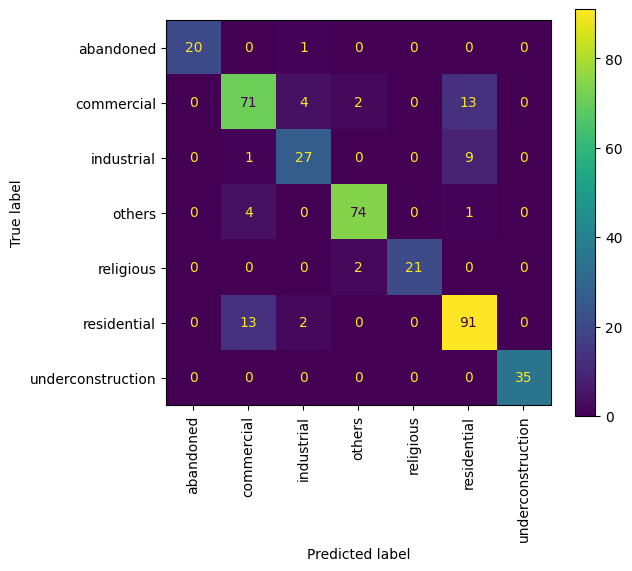

In [26]:
eval_model(model, test_loader)

Evaluating the model based on test images with predicted and actual label

In [27]:
model.eval()
with torch.no_grad():
    imgs, labels= next(iter(test_loader))   #Selecting a batch from the test dataloader 
    imgs= imgs.to(device)
    labels= labels.to(device)
    out=model(imgs)
    x, preds=torch.max(out.logits,1)

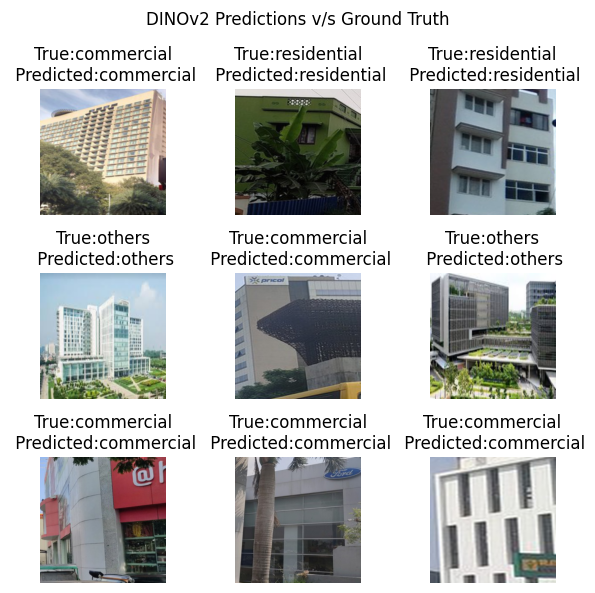

In [28]:
fig, ax= plt.subplots(nrows=3, ncols=3, figsize=[6,6])
all_labels=train_dataset.labels
fig.suptitle('DINOv2 Predictions v/s Ground Truth')
for i,axi in enumerate(ax.flat):
    img=imgs[i].cpu()
    true_label=labels[i].cpu()
    
    img=transforms.ToPILImage()(img)
    axi.imshow(img)
    axi.set_title(f'True:{all_labels[true_label]}\n Predicted:{all_labels[preds[i]]}')
    axi.axis('off')
plt.tight_layout()
plt.show()
    

In [29]:
torch.cuda.empty_cache()

# Saving the model weights for later use

In [30]:
torch.save(model.state_dict(), 'dinov2_phase1.pth')

In [31]:
for name,param in model.named_parameters():
    if param.requires_grad:
        print(name,':',param)

classifier.weight : Parameter containing:
tensor([[-0.0118,  0.0084,  0.0279,  ..., -0.0192,  0.0095, -0.0201],
        [ 0.0773, -0.0750,  0.0304,  ...,  0.0292,  0.0244,  0.0197],
        [ 0.0105,  0.0150, -0.0077,  ..., -0.0409,  0.0184, -0.0318],
        ...,
        [-0.0117, -0.0028, -0.0145,  ..., -0.0095,  0.0197,  0.0086],
        [-0.0914,  0.0388,  0.0008,  ..., -0.0026, -0.0334, -0.0245],
        [ 0.0153,  0.0355,  0.0273,  ...,  0.0324, -0.0088,  0.0010]],
       device='cuda:1', requires_grad=True)
classifier.bias : Parameter containing:
tensor([-0.0254,  0.0099, -0.0246,  0.0125,  0.0124, -0.0220, -0.0278],
       device='cuda:1', requires_grad=True)
